# Fit 2D Hist

Example to fit two histograms at the same time via TVirtualFitter

To execute this tutorial, you can do:

```cpp
root > .x fit2dHist.C  (executing via CINT, slow)
```

  or
```cpp
root > .x fit2dHist.C+     (executing via ACLIC , fast, with Minuit)
root > .x fit2dHist.C+(2)  (executing via ACLIC , fast, with Minuit2)
```

  or using the option to fit independently the 2 histos
```cpp
root > .x fit2dHist.C+(10) (via ACLIC, fast, independent fits with Minuit)
root > .x fit2dHist.C+(12) (via ACLIC, fast, independent fits with Minuit2)
```

Note that you can also execute this script in batch with eg,
```cpp
 root -b -q "fit2dHist.C+(12)"
```

or execute interactively from the shell
```cpp
 root fit2dHist.C+
 root "fit2dHist.C+(12)"
```




**Author:** : Lorenzo Moneta, Rene Brun 18/01/2006  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 01:28 AM.</small></i>

In [1]:
%%cpp -d
#include "TH2D.h"
#include "TF2.h"
#include "TCanvas.h"
#include "TStyle.h"
#include "TRandom3.h"
#include "TVirtualFitter.h"
#include "TList.h"

#include <iostream>

Data need to be globals to be visible by fcn

In [2]:
TRandom3 rndm;
TH2D *h1, *h2;
Int_t npfits;

 A helper function is created: 

In [3]:
%%cpp -d
double gauss2D(double *x, double *par) {
   double z1 = double((x[0]-par[1])/par[2]);
   double z2 = double((x[1]-par[3])/par[4]);
   return par[0]*exp(-0.5*(z1*z1+z2*z2));
}

 A helper function is created: 

In [4]:
%%cpp -d
double my2Dfunc(double *x, double *par) {
   return gauss2D(x,&par[0]) + gauss2D(x,&par[5]);
}

 A helper function is created: 

In [5]:
%%cpp -d
void myFcn(Int_t & /*nPar*/, Double_t * /*grad*/ , Double_t &fval, Double_t *p, Int_t /*iflag */  )
{
   TAxis *xaxis1  = h1->GetXaxis();
   TAxis *yaxis1  = h1->GetYaxis();
   TAxis *xaxis2  = h2->GetXaxis();
   TAxis *yaxis2  = h2->GetYaxis();

   int nbinX1 = h1->GetNbinsX();
   int nbinY1 = h1->GetNbinsY();
   int nbinX2 = h2->GetNbinsX();
   int nbinY2 = h2->GetNbinsY();

   double chi2 = 0;
   double x[2];
   double tmp;
   npfits = 0;
   for (int ix = 1; ix <= nbinX1; ++ix) {
      x[0] = xaxis1->GetBinCenter(ix);
      for (int iy = 1; iy <= nbinY1; ++iy) {
         if ( h1->GetBinError(ix,iy) > 0 ) {
         x[1] = yaxis1->GetBinCenter(iy);
         tmp = (h1->GetBinContent(ix,iy) - my2Dfunc(x,p))/h1->GetBinError(ix,iy);
         chi2 += tmp*tmp;
         npfits++;
         }
      }
   }
   for (int ix = 1; ix <= nbinX2; ++ix) {
      x[0] = xaxis2->GetBinCenter(ix);
      for (int iy = 1; iy <= nbinY2; ++iy) {
         if ( h2->GetBinError(ix,iy) > 0 ) {
         x[1] = yaxis2->GetBinCenter(iy);
         tmp = (h2->GetBinContent(ix,iy) - my2Dfunc(x,p))/h2->GetBinError(ix,iy);
         chi2 += tmp*tmp;
         npfits++;
         }
      }
   }
   fval = chi2;
}

 A helper function is created: 

In [6]:
%%cpp -d
void FillHisto(TH2D * h, int n, double * p) {


   const double mx1 = p[1];
   const double my1 = p[3];
   const double sx1 = p[2];
   const double sy1 = p[4];
   const double mx2 = p[6];
   const double my2 = p[8];
   const double sx2 = p[7];
   const double sy2 = p[9];
   //const double w1 = p[0]*sx1*sy1/(p[5]*sx2*sy2);
   const double w1 = 0.5;

   double x, y;
   for (int i = 0; i < n; ++i) {
      // generate randoms with larger gaussians
      rndm.Rannor(x,y);

      double r = rndm.Rndm(1);
      if (r < w1) {
         x = x*sx1 + mx1;
         y = y*sy1 + my1;
      }
      else {
         x = x*sx2 + mx2;
         y = y*sy2 + my2;
      }
      h->Fill(x,y);

   }
}

 Arguments are defined. 

In [7]:
int option=1;

Create two histograms

In [8]:
int nbx1 = 50;
int nby1 = 50;
int nbx2 = 50;
int nby2 = 50;
double xlow1 = 0.;
double ylow1 = 0.;
double xup1 = 10.;
double yup1 = 10.;
double xlow2 = 5.;
double ylow2 = 5.;
double xup2 = 20.;
double yup2 = 20.;

h1 = new TH2D("h1","core",nbx1,xlow1,xup1,nby1,ylow1,yup1);
h2 = new TH2D("h2","tails",nbx2,xlow2,xup2,nby2,ylow2,yup2);

double iniParams[10] = { 100, 6., 2., 7., 3, 100, 12., 3., 11., 2. };

Create fit function

In [9]:
TF2 * func = new TF2("func",my2Dfunc,xlow2,xup2,ylow2,yup2, 10);
func->SetParameters(iniParams);

Fill histos

In [10]:
int n1 = 1000000;
int n2 = 1000000;
FillHisto(h1,n1,iniParams);
FillHisto(h2,n2,iniParams);

Scale histograms to same heights (for fitting)

In [11]:
double dx1 = (xup1-xlow1)/double(nbx1);
double dy1 = (yup1-ylow1)/double(nby1);
double dx2 = (xup2-xlow2)/double(nbx2);
double dy2 = (yup2-ylow2)/double(nby2);

Scale histo 2 to scale of 1

In [12]:
h2->Sumw2();
h2->Scale(  ( double(n1) * dx1 * dy1 )  / ( double(n2) * dx2 * dy2 ) );

bool global = false;
if (option > 10) global = true;
if (global) {
   // fill data structure for fit (coordinates + values + errors)
   std::cout << "Do global fit" << std::endl;
   // fit now all the function together

   //The default minimizer is Minuit, you can also try Minuit2
   if (option%10 == 2) TVirtualFitter::SetDefaultFitter("Minuit2");
   else                TVirtualFitter::SetDefaultFitter("Minuit");
   TVirtualFitter * minuit = TVirtualFitter::Fitter(0,10);
   for (int i = 0; i < 10; ++i) {
      minuit->SetParameter(i, func->GetParName(i), func->GetParameter(i), 0.01, 0,0);
   }
   minuit->SetFCN(myFcn);

   double arglist[100];
   arglist[0] = 0;
   // set print level
   minuit->ExecuteCommand("SET PRINT",arglist,2);

   // minimize
   arglist[0] = 5000; // number of function calls
   arglist[1] = 0.01; // tolerance
   minuit->ExecuteCommand("MIGRAD",arglist,2);

   //get result
   double minParams[10];
   double parErrors[10];
   for (int i = 0; i < 10; ++i) {
      minParams[i] = minuit->GetParameter(i);
      parErrors[i] = minuit->GetParError(i);
   }
   double chi2, edm, errdef;
   int nvpar, nparx;
   minuit->GetStats(chi2,edm,errdef,nvpar,nparx);

   func->SetParameters(minParams);
   func->SetParErrors(parErrors);
   func->SetChisquare(chi2);
   int ndf = npfits-nvpar;
   func->SetNDF(ndf);

   // add to list of functions
   h1->GetListOfFunctions()->Add(func);
   h2->GetListOfFunctions()->Add(func);
}
else {
   // fit independently
   h1->Fit(func);
   h2->Fit(func);
}

 FCN=2613.61 FROM MIGRAD    STATUS=CONVERGED    1090 CALLS        1091 TOTAL
                     EDM=1.55983e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.34104e+02   2.25626e+00  -1.45535e-03   2.18361e-05
   2  p1           6.00014e+00   5.67524e-03  -2.38293e-06  -3.27950e-02
   3  p2           1.98724e+00   3.63694e-03  -2.58780e-06  -5.51100e-03
   4  p3           7.02973e+00   2.65118e-02  -2.44327e-05  -1.18791e-02
   5  p4           2.99679e+00   1.39392e-02  -1.13808e-05   1.50290e-02
   6  p5           5.19346e+02   5.08272e+01   3.87338e-02  -2.41679e-05
   7  p6           1.15499e+01   4.81865e-01   5.78552e-04   4.63918e-03
   8  p7           2.72921e+00   2.57821e-01   2.95927e-04  -5.50363e-03
   9  p8           1.11977e+01   2.40323e-01  -9.65116e-05   7.16002e-03
  10  p9           2.08422e+0

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


 FCN=2220.46 FROM MIGRAD    STATUS=CONVERGED     333 CALLS         334 TOTAL
                     EDM=6.12523e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.30875e+02   1.56318e+00  -8.45952e-04   2.13122e-04
   2  p1           6.01215e+00   1.39029e-02   5.56972e-05   1.20141e-01
   3  p2           1.99424e+00   1.02676e-02  -3.65136e-05   1.99144e-01
   4  p3           6.98634e+00   1.77537e-02   4.59090e-06   1.88055e-02
   5  p4           2.98764e+00   1.14564e-02   5.16036e-06   2.41586e-02
   6  p5           5.32751e+02   1.16044e+00   9.85151e-04   1.59278e-03
   7  p6           1.19894e+01   8.92126e-03   7.18452e-06   8.54790e-02
   8  p7           2.99536e+00   6.32688e-03  -5.28470e-06   3.40896e-01
   9  p8           1.09975e+01   3.41959e-03  -1.79221e-06   2.14025e-02
  10  p9           1.98880e+0

Create a new canvas.

In [13]:
TCanvas * c1 = new TCanvas("c1","Two HIstogram Fit example",100,10,900,800);
c1->Divide(2,2);
gStyle->SetOptFit();
gStyle->SetStatY(0.6);

c1->cd(1);
h1->Draw();
func->SetRange(xlow1,ylow1,xup1,yup1);
func->DrawCopy("cont1 same");
c1->cd(2);
h1->Draw("lego");
func->DrawCopy("surf1 same");
c1->cd(3);
func->SetRange(xlow2,ylow2,xup2,yup2);
h2->Draw();
func->DrawCopy("cont1 same");
c1->cd(4);
h2->Draw("lego");
gPad->SetLogz();
func->Draw("surf1 same");

return 0;

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Draw all canvases 

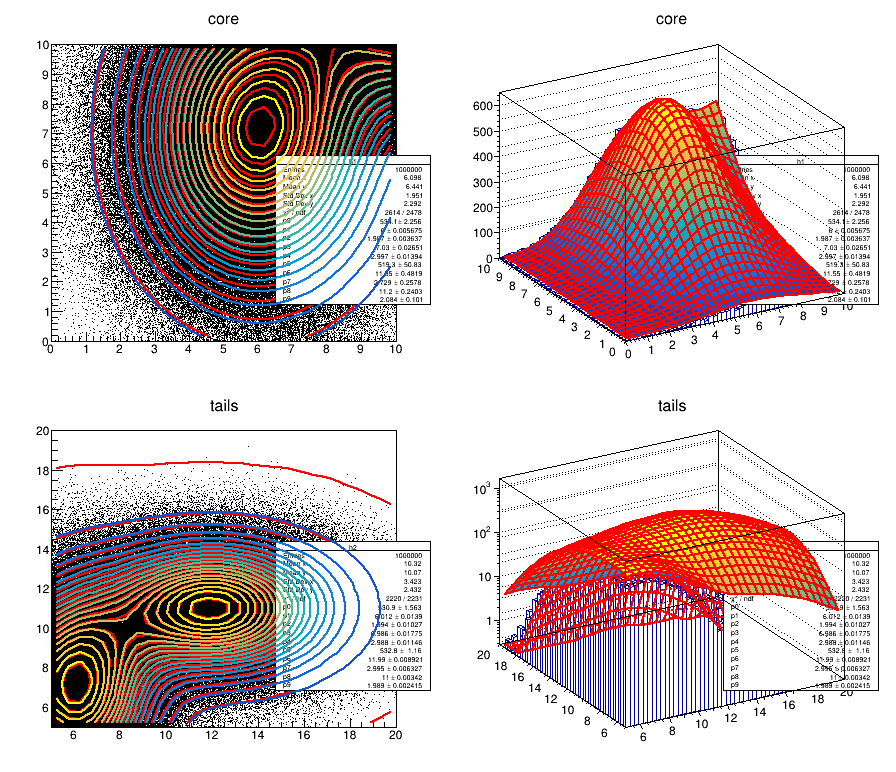

In [14]:
gROOT->GetListOfCanvases()->Draw()